# 数据

In [ ]:
!pip install -q "labelbox[data]"

     |████████████████████████████████| 162 kB 31.8 MB/s 
     |████████████████████████████████| 10.9 MB 57.4 MB/s 
     |████████████████████████████████| 6.3 MB 41.5 MB/s 


In [ ]:
from labelbox import Client, OntologyBuilder
from labelbox.data.annotation_types import Geometry
from labelbox.data.annotation_types.collection import LabelList
from PIL import Image
import numpy as np
import os
import torch

In [ ]:
class SegClsName:
  VESSEL = "血管"
  BRONCHUS = "支气管"

  def get_all_names():
    return ['支气管', '血管']

class VesselRatingName:
  D = "D血管周围浸润"

class BronchusRatingName:
  A = "A支气管浸润"
  B = "B支气管浸润定性"
  C = "C支气管腔渗出"

  def get_all_names():
    return ["A支气管浸润", "B支气管浸润定性", "C支气管腔渗出"]

In [ ]:
API_KEY = "yours"
PROJECT_ID = "yours"
client = Client(api_key=API_KEY)
project = client.get_project(PROJECT_ID)
labels = project.label_generator().as_list()

/usr/local/lib/python3.7/dist-packages/labelbox/data/annotation_types/classification/classification.py:85: UserWarning: Dropdown classification is deprecated and will be removed in a future release
  warnings.warn("Dropdown classification is deprecated and will be "


In [ ]:
def segmentation_cls_filter(lb_labels: LabelList, cls_name):
  '''取存在特定实体标签的样本'''
  result = LabelList()
  for lb in lb_labels:
    for a in lb.annotations:
      # print(a.name)
      if a.name == cls_name:
        result.append(lb)
        break

  return result

In [ ]:
a = [1,2,3,4,5]
b = (a, a)
next(zip(b))

([1, 2, 3, 4, 5],)

In [ ]:
from collections import Counter
from threading import Thread

def get_box_ratings(lb_labels: LabelList, cls_name, rating_name):
  
  def get_box(a):
    mask = a.value.draw()[:, :, 0]
    pos = np.where(mask != 0)
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    # 只针对 ResNet18 的约束
    if xmax - xmin > 32 or ymax - ymin > 32: 
      return [xmin, ymin, xmax, ymax] 
    return None

  def data_enhance(bs, rs):
    data_dict = {}
    for b,r in zip(bs, rs):
      if r not in data_dict.keys(): data_dict[r] = []
      data_dict[r].append(b)
    ctr = Counter(rs)
    max_num = max(list(ctr.values()))
    for r in data_dict.keys():
      if ctr[r] >= max_num: continue
      bs.extend(np.random.choice(data_dict[r], size=max_num-ctr[r]))
      rs.extend([r] * (max_num - ctr[r]))
      assert len(bs)==len(rs)      

  boxes = []
  ratings = []

  def parse(lb, a):
    if a.name != cls_name: return
    rating = [float(c.value.answer.name) for c in a.classifications if c.name == rating_name]
    if len(rating) == 0: return
    rating = rating[0]
    box = get_box(a)
    if box == None: return
    img = lb.data.value[box[1]:box[3]+1, box[0]:box[2]+1]
    boxes.append(img)
    ratings.append(rating)

  class ParsingThread(Thread):
    def __init__(self, lb, a):
      Thread.__init__(self)
      self.lb = lb
      self.a = a

    def run(self):
      parse(self.lb, self.a)

  ths = []
  for lb in lb_labels:
    for a in lb.object_annotations():
      ths.append(ParsingThread(lb, a))
  for t in ths: t.start()
  for t in ths: t.join()
  
  data_enhance(boxes, ratings)
  
  return boxes, ratings

In [ ]:
import torch

class BoxRatingDataset(torch.utils.data.Dataset):
  def __init__(self, lb_labels, cls_name, rating_name, transforms=None):
    self.transforms = transforms
    
    assert cls_name in SegClsName.get_all_names()
    if cls_name == SegClsName.BRONCHUS:
      assert rating_name in BronchusRatingName.get_all_names()
    elif cls_name == SegClsName.VESSEL:
      assert rating_name == VesselRatingName.D
    else:
      raise NotImplementedError("%s in %s"%(rating_name, cls_name))
    
    self.cls_name = cls_name
    self.rating_name = rating_name
    self.boxes, self.ratings = get_box_ratings(lb_labels, cls_name, rating_name)

  def __getitem__(self, idx):
    return self.boxes[idx], self.ratings[idx]

  def __len__(self):
    return len(self.ratings)

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 121496, done.
remote: Counting objects: 100% (14158/14158), done.
remote: Compressing objects: 100% (1168/1168), done.
remote: Total 121496 (delta 13048), reused 13921 (delta 12922), pack-reused 107338
Receiving objects: 100% (121496/121496), 234.92 MiB | 38.83 MiB/s, done.
Resolving deltas: 100% (105731/105731), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# 模型

In [ ]:
from torchvision import models
from torch.hub import load_state_dict_from_url
from torch import nn

class BoxRatingResNet18(models.ResNet):

  def __init__(self, upper=3, pretrained=False, **kwargs):

    # Start with standard resnet18 defined here
    super().__init__(block = models.resnet.BasicBlock, layers = [2, 2, 2, 2], num_classes = 1000, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(models.resnet.model_urls["resnet18"], progress=True)
        self.load_state_dict(state_dict)

    # Replace AdaptiveAvgPool2d with standard AvgPool2d
    # self.avgpool = nn.AvgPool2d((7, 7))

    # Convert the original fc layer to a convolutional layer.  
    self.last_conv = torch.nn.Conv2d(in_channels=self.fc.in_features, out_channels=1000, kernel_size=1)
    self.last_conv.weight.data.copy_(self.fc.weight.data.view(*self.fc.weight.data.shape, 1, 1))
    self.last_conv.bias.data.copy_(self.fc.bias.data)

    self.reg_layer = nn.Linear(1000, 1)
    self.upper = upper

  # Reimplementing forward pass.
  def _forward_impl(self, x):
    # Standard forward for resnet18
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgpool(x)

    # Notice, there is no forward pass
    # through the original fully connected layer.
    # Instead, we forward pass through the last conv layer
    x = self.last_conv(x)
    x = x.squeeze(-1).squeeze(-1)
    # print(x.size())
    x = self.reg_layer(x)
    x = nn.functional.sigmoid(x).mul(float(self.upper))
    return x

In [ ]:
from collections import Counter
dataset = BoxRatingDataset(labels, SegClsName.BRONCHUS, BronchusRatingName.B, get_transform(train=True))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


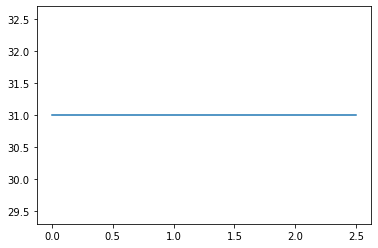

In [ ]:
from matplotlib import pyplot as plt

ctr = Counter([r for _, r in dataset])

keys = sorted(list(ctr.keys()))
nums = [ctr[k] for k in keys]
plt.plot(keys, nums)

# 训练

In [ ]:
dataset = BoxRatingDataset(labels, SegClsName.BRONCHUS, BronchusRatingName.A, get_transform(train=True))
dataset_test = BoxRatingDataset(labels, SegClsName.BRONCHUS, BronchusRatingName.A, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-5])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-5:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = BoxRatingResNet18(pretrained=True)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)
loss_fn = torch.nn.MSELoss()

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
from_scratch = True
n_epoch = 50
log_freq = 10

if not from_scratch:
  model.load_state_dict(torch.load("./model.pt"))

train_losses, test_losses = [], []

for epoch in range(n_epoch):
  tmp_losses = []
  for i, (imgs, lbs) in enumerate(iter(data_loader)):
    optimizer.zero_grad()
    preds = []
    for im, _ in zip(imgs, lbs):
      pred = model(torch.Tensor(im).permute(2, 0, 1).unsqueeze(0).to(device))[0]
      preds.append(pred)
    # print(torch.cat(preds).dtype, torch.tensor(lbs).dtype)
    loss = loss_fn(torch.cat(preds), torch.tensor(lbs).to(device))
    tmp_losses.append(loss)

    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    if i % log_freq == 0:
      print("epoch[%d] train[%d/%d] train_loss=%f"%(epoch, 
          i*data_loader.batch_size, len(data_loader.dataset), 
          torch.tensor(tmp_losses).sum()/len(tmp_losses)))
      train_losses.append(torch.tensor(tmp_losses).sum()/len(tmp_losses))
      tmp_losses = []

  tmp_losses = []
  for i, (imgs, lbs) in enumerate(iter(data_loader_test)):
    with torch.no_grad():
      preds = []
      for im, _ in zip(imgs, lbs):
        pred = model(torch.Tensor(im).permute(2, 0, 1).unsqueeze(0).to(device))[0]
        preds.append(pred)
      loss = loss_fn(torch.cat(preds), torch.tensor(lbs).to(device)).view(-1)

      tmp_losses.append(loss)
      print("epoch[%d] test[%d/%d] val_loss=%f"%(epoch, 
          i*data_loader_test.batch_size, len(data_loader_test.dataset), loss))
  test_losses.append(torch.cat(tmp_losses).sum()/len(tmp_losses))
  print("test completed. avg_val_loss=%f"%(test_losses[-1]))

    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch[0] train[0/135] train_loss=2.001101
epoch[0] train[20/135] train_loss=1.027679
epoch[0] train[40/135] train_loss=1.351558
epoch[0] train[60/135] train_loss=1.045575
epoch[0] train[80/135] train_loss=1.166937
epoch[0] train[100/135] train_loss=1.161464
epoch[0] train[120/135] train_loss=0.824526
epoch[0] test[0/5] val_loss=0.671481
epoch[0] test[1/5] val_loss=0.387884
epoch[0] test[2/5] val_loss=3.346150
epoch[0] test[3/5] val_loss=0.036305
epoch[0] test[4/5] val_loss=0.055207
test completed. avg_val_loss=0.055207
epoch[1] train[0/135] train_loss=0.045067
epoch[1] train[20/135] train_loss=1.030669
epoch[1] train[40/135] train_loss=1.143377
epoch[1] train[60/135] train_loss=0.972854
epoch[1] train[80/135] train_loss=1.179356
epoch[1] train[100/135] train_loss=0.991507
epoch[1] train[120/135] train_loss=1.096780
epoch[1] test[0/5] val_loss=0.671481
epoch[1] test[1/5] val_loss=0.387884
epoch[1] test[2/5] val_loss=3.346150
epoch[1] test[3/5] val_loss=0.036305
epoch[1] test[4/5] val_lo

In [ ]:
a = torch.tensor((3.,), requires_grad=True)
b = torch.tensor((4.,), requires_grad=True)
c = a+b
a1 = torch.tensor((3.,), requires_grad=True)
b1 = torch.tensor((4.,), requires_grad=True)
c1 = a1+b1
d = torch.cat([c, c1])
loss = loss_fn(d, torch.ones((2,)))
loss.backward()
a.grad, b.grad

(tensor([6.]), tensor([6.]))

In [ ]:
a, (b, c) = (1, (2, 3))
a, b, c

(1, 2, 3)

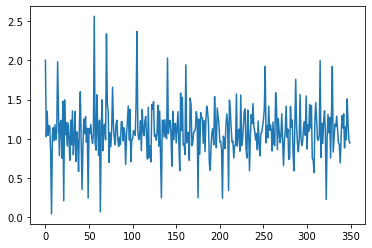

In [ ]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(train_losses).cpu())

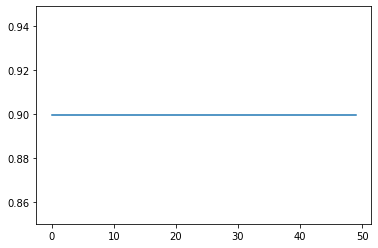

In [ ]:
plt.plot(torch.tensor(test_losses).cpu())